## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(sys)

2.154434690031884
Eff_area


In [4]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.13 s, sys: 169 ms, total: 6.3 s
Wall time: 6.31 s


## Datasets

In [5]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    
    
if sys == "E_reco":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
    dataset_asimov_N.irf_model.parameters['norm'].frozen = True
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)    


## Minos

In [6]:
        
numpoints = 5

In [7]:
def computing_contour(dataset, note):
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset)
    print(dataset_asimov.models[0])
    
    results = []
    for parname1, parname2 in parameter_names :
        print( parname1, parname2)
        minuit_opts = {"tol": 0.01, "strategy": 1}
        fit_cor.backend = "minuit"
        fit_cor.optimize_opts = minuit_opts
        result = fit_cor.stat_contour(dataset,
                             dataset.models.parameters[parname1],
                             dataset.models.parameters[parname2],
                                      numpoints=numpoints 
                            )

        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "success":
                contour_write[k] = result[k].tolist()

        with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)

        fig = plt.figure()
        plt.plot(result[f"{dataset.models[0].name}.spectral.{parname1}"],
        result[f"{dataset.models[0].name}.spectral.{parname2}"])
        results.append(result)
        
def read_in_contour(note):
    results = []
    for parname1, parname2 in parameter_names :
        with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        results.append(contour)
    return results

SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.09             
    amplitude                     :   3.85e-11   +/- 2.5e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.100   +/-    0.04 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         


amplitude index
Crablog.spectral.amplitude
Crablog.spectral.index
success
amplitude lambda_
Crablog.spectral.amplitude
Crablog.spectral.lambda_
success
lambda_ index
Crablog.spectral.lambda_
Crablog.spectral.index
success
CPU times: user 2min 4s, sys: 44.4

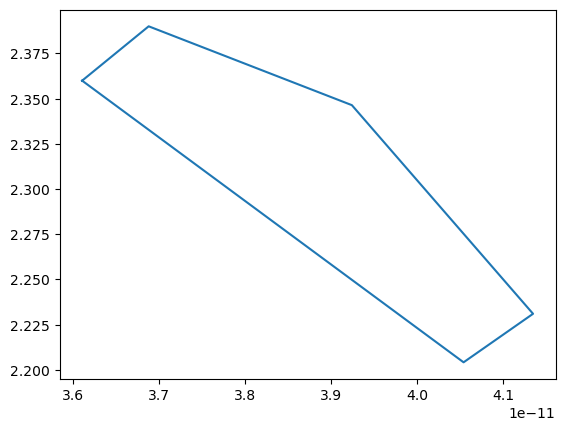

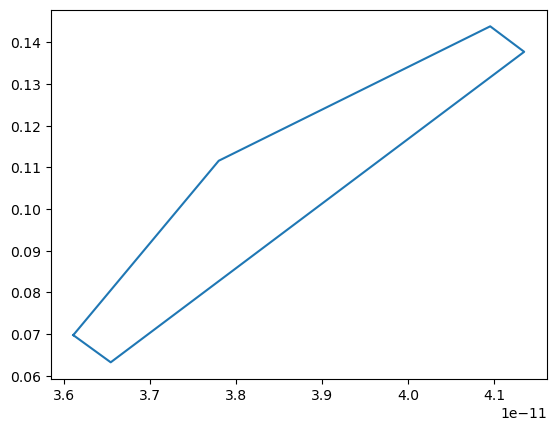

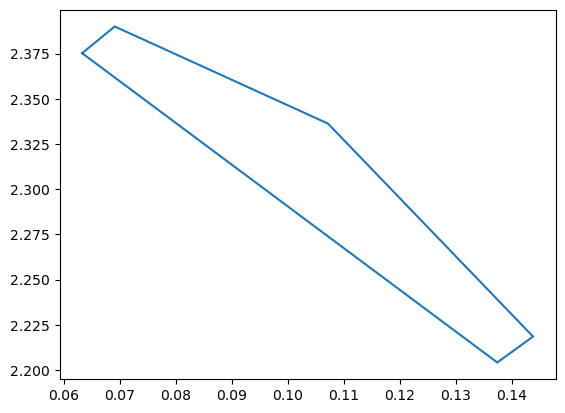

In [8]:
%%time
computing = 1
if computing:
    results = computing_contour(dataset_asimov, "2.15h")
else:
    results = read_in_contour("2.15h")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    


In [ ]:
%%time
computing = 1
if computing:
    results_N = computing_contour(dataset_asimov_N, "N_2.15h")
else:
    results_N = read_in_contour("N_2.15h")
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        


SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.09             
    amplitude                     :   3.85e-11   +/- 2.5e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.100   +/-    0.04 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         


amplitude index
Crablog.spectral.amplitude
Crablog.spectral.index
success
amplitude lambda_


In [ ]:
fig,axs = plt.subplots(2,2)
#axs = axs.flatten()
axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
for i,p in enumerate(parameter_names):
    a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    axs[i].plot(a, b, color = awo[0])
    axs[i].errorbar(x = dataset_asimov.models[0].parameters[p[0]].value,
                    y = dataset_asimov.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov.models[0].parameters[p[1]].error,
                    color = awo[0],
                    capsize = 6,
                    label = "fit w/o systematic"
                    
                   )
    
    a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    axs[i].plot(a, b, color = aw[0])
    axs[i].errorbar(x = dataset_asimov_N.models[0].parameters[p[0]].value,
                    y = dataset_asimov_N.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov_N.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov_N.models[0].parameters[p[1]].error,
                    color = aw[0],
                    capsize = 6,
                    label = "fit with systematic"
                   )
    axs[i].errorbar(x = dataset_input.models[0].parameters[p[0]].value,
                    y = dataset_input.models[0].parameters[p[1]].value,
                    color = 'black',
                    marker = 'v',
                    capsize = 6,
                    label = "input"
                   )
    axs[i].set_xlabel(p[0])
    axs[i].set_ylabel(p[1])  
plt.tight_layout()
axs[-1].axis('off')
plt.savefig(f"../{c['folder']}/plots/3_contours.pdf")